In [105]:
from collections import deque
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## Описательная статистика датасета

In [106]:
ROOT = Path("..")

data_path = ROOT / "data" / "processed" / "match_features.csv"

df = pd.read_csv(data_path)
df.head()

,game_id,date,season,home_team_id,away_team_id,home_win,home_goals_L3,away_goals_L3,home_goals_L5,away_goals_L5,home_shots_L3,away_shots_L3,home_goalie_save_L3,away_goalie_save_L3
0,1999020507,1999-12-29,19992000,1,6,1,4.000000,0.000000,4.00,0.000000,32.000000,34.000000,0.950000,NaN
1,2009020576,2009-12-28,20092010,1,11,1,3.666667,1.333333,3.75,1.333333,34.333333,24.666667,0.897639,NaN
2,2009020591,2009-12-30,20092010,1,5,1,3.000000,5.333333,3.60,4.500000,31.666667,36.000000,0.916442,NaN
3,2009020630,2010-01-05,20092010,1,25,1,2.666667,3.666667,3.00,4.000000,28.666667,32.666667,0.922454,NaN
4,2009020655,2010-01-08,20092010,1,14,0,3.333333,2.333333,3.00,2.800000,26.666667,37.000000,0.922454,0.920513


In [107]:
df.dtypes.sort_values

<bound method Series.sort_values of game_id                  int64
date                    object
season                   int64
home_team_id             int64
away_team_id             int64
home_win                 int64
home_goals_L3          float64
away_goals_L3          float64
home_goals_L5          float64
away_goals_L5          float64
home_shots_L3          float64
away_shots_L3          float64
home_goalie_save_L3    float64
away_goalie_save_L3    float64
dtype: object>

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22194 entries, 0 to 22193
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   game_id              22194 non-null  int64  
 1   date                 22194 non-null  object 
 2   season               22194 non-null  int64  
 3   home_team_id         22194 non-null  int64  
 4   away_team_id         22194 non-null  int64  
 5   home_win             22194 non-null  int64  
 6   home_goals_L3        22194 non-null  float64
 7   away_goals_L3        22194 non-null  float64
 8   home_goals_L5        22194 non-null  float64
 9   away_goals_L5        22194 non-null  float64
 10  home_shots_L3        22128 non-null  float64
 11  away_shots_L3        22125 non-null  float64
 12  home_goalie_save_L3  20537 non-null  float64
 13  away_goalie_save_L3  20450 non-null  float64
dtypes: float64(8), int64(5), object(1)
memory usage: 2.4+ MB


In [109]:
df.describe()

,game_id,season,home_team_id,away_team_id,home_win,home_goals_L3,away_goals_L3,home_goals_L5,away_goals_L5,home_shots_L3,away_shots_L3,home_goalie_save_L3,away_goalie_save_L3
count,2.219400e+04,2.219400e+04,22194.000000,22194.000000,22194.000000,22194.000000,22194.000000,22194.000000,22194.000000,22128.000000,22125.000000,20537.000000,20450.000000
mean,2.017148e+09,2.017329e+07,33.034964,31.427323,0.544426,2.890594,2.926669,2.898222,2.919276,30.148108,30.280655,0.902902,0.900646
std,4.729131e+06,4.729926e+04,320.793470,305.194849,0.498034,1.000105,1.008998,0.802479,0.806321,4.436725,4.500626,0.043285,0.044629
min,1.999021e+09,1.999200e+07,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,12.000000,0.500000,0.461905
25%,2.013021e+09,2.013201e+07,8.000000,8.000000,0.000000,2.333333,2.333333,2.400000,2.400000,27.000000,27.333333,0.882557,0.879651
50%,2.017021e+09,2.017202e+07,17.000000,17.000000,1.000000,3.000000,3.000000,2.800000,2.800000,30.000000,30.000000,0.908768,0.907200
75%,2.021021e+09,2.021202e+07,25.000000,25.000000,1.000000,3.666667,3.666667,3.400000,3.400000,33.000000,33.333333,0.931357,0.930057
max,2.025021e+09,2.025203e+07,7801.000000,7802.000000,1.000000,9.000000,9.000000,9.000000,9.000000,58.000000,55.666667,1.000000,1.000000


In [110]:
df.shape

(22194, 14)

In [111]:
df["date"].min(), df["date"].max()

('1999-12-28', '2026-01-04')

In [112]:
df["season"].nunique()

18

На данный момент пока что собрано 22194 матчей НХЛ за период с 2000 по 2025 год включительно (18 сезонов).

In [113]:
missing = df.isna().mean().sort_values(ascending=False)
missing[missing > 0]

away_goalie_save_L3    0.078580
home_goalie_save_L3    0.074660
away_shots_L3          0.003109
home_shots_L3          0.002974
dtype: float64

Заполним `shots` медианой по лиге, а `goalie_save` средним по лиге.

In [114]:
shot_cols = ["home_shots_L3", "away_shots_L3"]
goalie_cols = ["home_goalie_save_L3", "away_goalie_save_L3"]

shot_medians = df[shot_cols].median()
goalie_means = df[goalie_cols].mean()

In [115]:
for col in shot_cols:
    df[col] = df[col].fillna(shot_medians[col])

for col in goalie_cols:
    df[col] = df[col].fillna(goalie_means[col])

In [116]:
df.duplicated().sum()

np.int64(0)

In [117]:
df["game_id"].duplicated().sum()

np.int64(0)

In [118]:
assert (df["home_goals_L3"] >= 0).all()
assert (df["home_goals_L5"] >= 0).all()
assert (df["away_goals_L3"] >= 0).all()
assert (df["away_goals_L5"] >= 0).all()

In [119]:
df["home_win"].value_counts(normalize=True)

home_win
1    0.544426
0    0.455574
Name: proportion, dtype: float64

## Распределение ключевых признаков

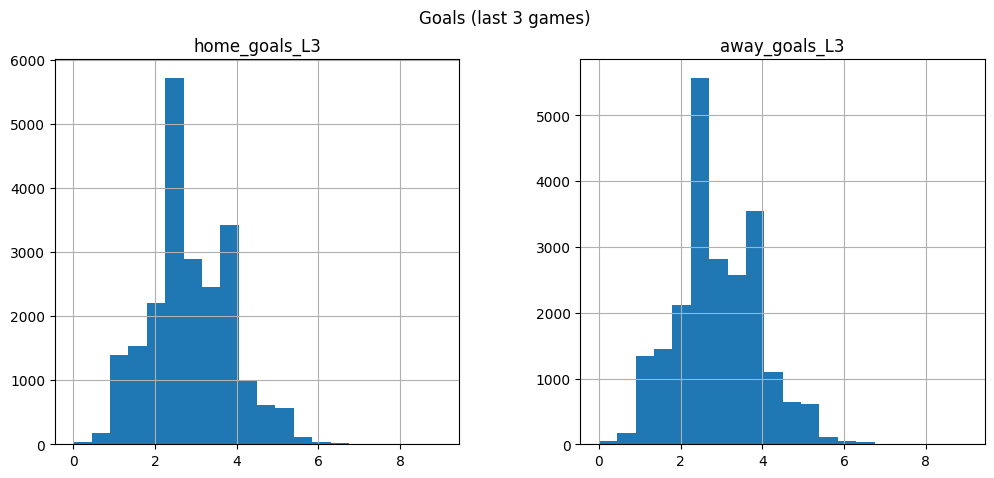

In [120]:
df[["home_goals_L3", "away_goals_L3"]].hist(bins=20, figsize=(12, 5))
plt.suptitle("Goals (last 3 games)")
plt.show()

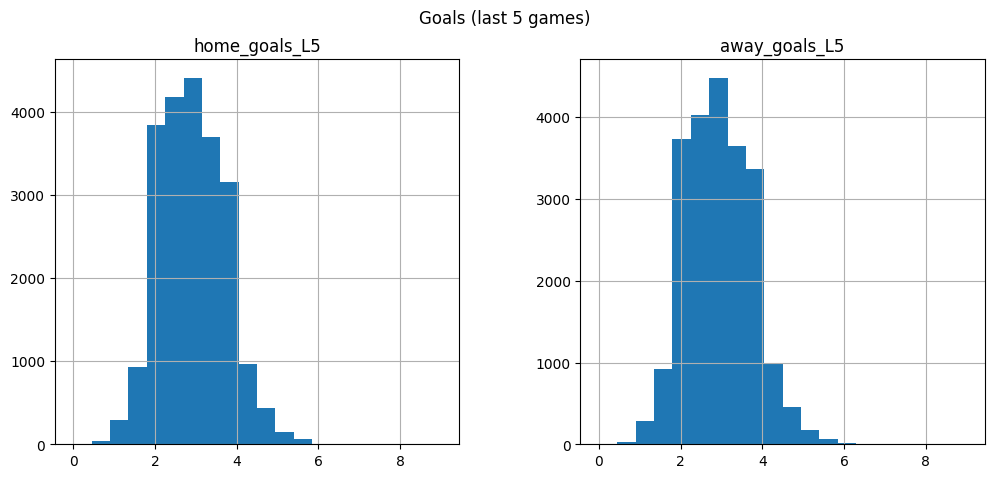

In [121]:
df[["home_goals_L5", "away_goals_L5"]].hist(bins=20, figsize=(12, 5))
plt.suptitle("Goals (last 5 games)")
plt.show()

In [122]:
df.groupby("home_win")["home_goals_L3"].mean()

home_win
0    2.866828
1    2.910480
Name: home_goals_L3, dtype: float64

Выводы по обзору данных:
- Полных дубликатов, а также дубликатов по `game_id` в датасете не наблюдается, что подтверждает корректность процедуры сбора и агрегации данных;
- Целевая переменная `home_win` не имеет выраженного дисбаланса классов: доля побед домашней команды составляет около 54%, поражений — около 46%. Такое соотношение соответствует известному эффекту домашнего преимущества в НХЛ и не требует применения специальных техник балансировки на этапе baseline-моделирования.
- Для построения базового решения были сформированы `rolling-фичи` с окнами L3 и L5, отражающие показатели команды за последние 3 и 5 матчей соответственно. Использование таких агрегатов позволяет учитывать краткосрочную и среднесрочную динамику формы команды, что особенно важно для спортивных временных рядов, где текущая форма может существенно влиять на исход матча.

## Корреляции

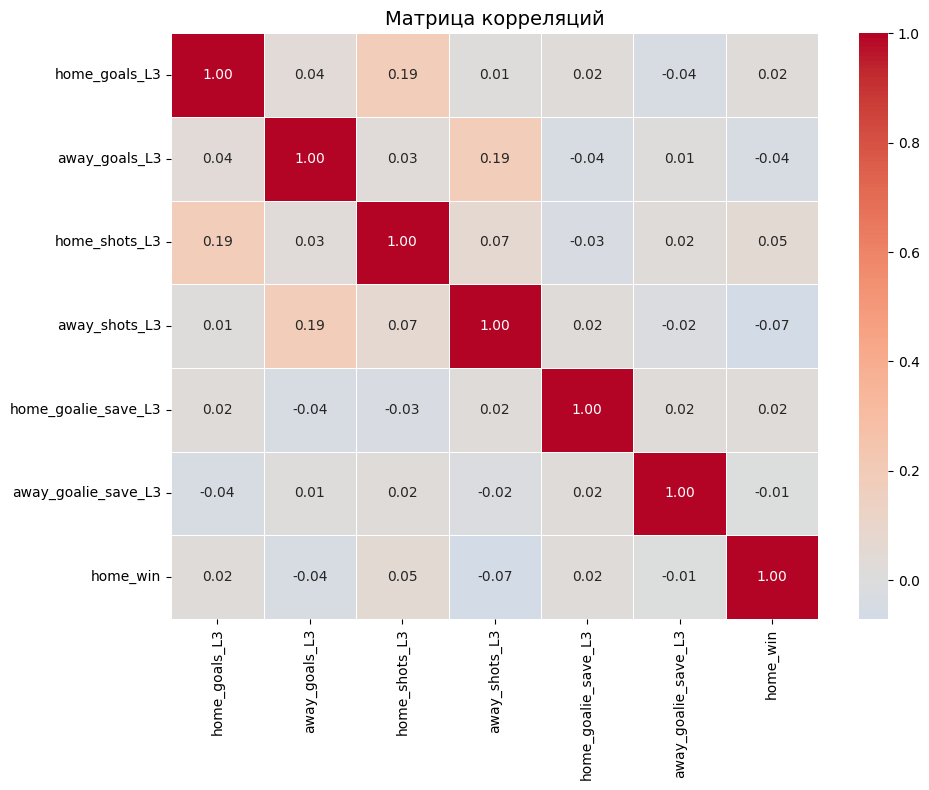

In [123]:
corr = df[
    [
        "home_goals_L3",
        "away_goals_L3",
        "home_shots_L3",
        "away_shots_L3",
        "home_goalie_save_L3",
        "away_goalie_save_L3",
        "home_win",
    ]
].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)

plt.title("Матрица корреляций", fontsize=14)
plt.tight_layout()
plt.show()

## Простой бейзлайн с `LogisticRegression`

In [124]:
pipe = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=1000))])

In [125]:
features = ["home_goals_L3", "away_goals_L3", "home_shots_L3", "away_shots_L3"]
target = "home_win"

X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.2, shuffle=False
)

pipe.fit(X_train, y_train)

preds = pipe.predict(X_test)
probs = pipe.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, preds))
print("ROC-AUC:", roc_auc_score(y_test, probs))

Accuracy: 0.5489975219644064
ROC-AUC: 0.5672071877850201


Вывводы:

Базовая модель логистической регрессии была обучена с использованием скользящей статистики атак (голы и броски по воротам за последние 3 игры).
Несмотря на простоту набора характеристик, модель достигла значения ROC-AUC, равного 0,57, что указывает на наличие прогнозирующего сигнала и подтверждает правильность выбранного подхода к разработке характеристик.

## Попытка улучшить бейзлайн: легкий feature engineering.

Добавим следующие признаки, влияющие на состояние команды перед очередной встречей:

- rest_days_home, rest_days_away - количество дней после предыдущего матча
- back_to_back_home, back_to_back_away - игра два дня подряд
- home_games_last_7, away_games_last_7 - количество сыгранных матчей в последние 7 дней

In [126]:
df = df.sort_values("date").reset_index(drop=True)

last_game_date = {}

rest_days_home = []
rest_days_away = []
back_to_back_home = []
back_to_back_away = []

for _idx, row in df.iterrows():
    home = row["home_team_id"]
    away = row["away_team_id"]
    game_date = pd.to_datetime(row["date"])

    if home in last_game_date:
        delta = (game_date - last_game_date[home]).days
        rest_days_home.append(delta)
        back_to_back_home.append(1 if delta == 1 else 0)
    else:
        rest_days_home.append(None)
        back_to_back_home.append(0)
    last_game_date[home] = game_date

    if away in last_game_date:
        delta = (game_date - last_game_date[away]).days
        rest_days_away.append(delta)
        back_to_back_away.append(1 if delta == 1 else 0)
    else:
        rest_days_away.append(None)
        back_to_back_away.append(0)
    last_game_date[away] = game_date

df["rest_days_home"] = rest_days_home
df["rest_days_away"] = rest_days_away
df["back_to_back_home"] = back_to_back_home
df["back_to_back_away"] = back_to_back_away

In [127]:
DAYS_WINDOW = 7
last_7_games = {}

games_last_7_home = []
games_last_7_away = []

for _idx, row in df.iterrows():
    home = row["home_team_id"]
    away = row["away_team_id"]
    game_date = pd.to_datetime(row["date"])

    # Home
    if home not in last_7_games:
        last_7_games[home] = deque()

    while last_7_games[home] and (game_date - last_7_games[home][0]).days > DAYS_WINDOW:
        last_7_games[home].popleft()
    games_last_7_home.append(len(last_7_games[home]))
    last_7_games[home].append(game_date)

    # Away
    if away not in last_7_games:
        last_7_games[away] = deque()
    while last_7_games[away] and (game_date - last_7_games[away][0]).days > DAYS_WINDOW:
        last_7_games[away].popleft()
    games_last_7_away.append(len(last_7_games[away]))
    last_7_games[away].append(game_date)

df["games_last_7_home"] = games_last_7_home
df["games_last_7_away"] = games_last_7_away

In [128]:
df["rest_diff"] = df["rest_days_home"] - df["rest_days_away"]
df["back2back_diff"] = df["back_to_back_home"] - df["back_to_back_away"]
df["games_last7_diff"] = df["games_last_7_home"] - df["games_last_7_away"]

In [129]:
# Заполнение пропусков: первые матчи команд заполняем средним.
df[["rest_days_home", "rest_days_away", "rest_diff"]] = df[
    ["rest_days_home", "rest_days_away", "rest_diff"]
].fillna(3)

In [130]:
df.head()

,game_id,date,season,home_team_id,away_team_id,home_win,home_goals_L3,away_goals_L3,home_goals_L5,away_goals_L5,...,away_goalie_save_L3,rest_days_home,rest_days_away,back_to_back_home,back_to_back_away,games_last_7_home,games_last_7_away,rest_diff,back2back_diff,games_last7_diff
0,1999020503,1999-12-28,19992000,7,17,0,1.0,3.0,1.0,3.0,...,0.913043,3.0,3.0,0,0,0,0,3.0,0,0
1,1999020507,1999-12-29,19992000,1,6,1,4.0,0.0,4.0,0.0,...,0.900646,3.0,3.0,0,0,0,0,3.0,0,0
2,1999020510,1999-12-29,19992000,25,3,1,1.0,2.0,1.0,2.0,...,0.900646,3.0,3.0,0,0,0,0,3.0,0,0
3,1999020512,1999-12-29,19992000,20,24,1,1.0,1.0,1.0,1.0,...,0.900646,3.0,3.0,0,0,0,0,3.0,0,0
4,1999020506,1999-12-29,19992000,8,9,0,4.0,4.0,4.0,4.0,...,0.900646,3.0,3.0,0,0,0,0,3.0,0,0


In [131]:
features = df.drop(columns=["game_id", "date", "season", "home_win"], axis=1)
target = "home_win"

X_train, X_test, y_train, y_test = train_test_split(
    features, df[target], test_size=0.2, shuffle=False
)

pipe.fit(X_train, y_train)

preds = pipe.predict(X_test)
probs = pipe.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, preds))
print("ROC-AUC:", roc_auc_score(y_test, probs))

Accuracy: 0.5501239017796801
ROC-AUC: 0.5672849487429886


На текущем этапе baseline-модель демонстрирует небольшое улучшение качества предсказаний по сравнению с наивным подходом (ROC-AUC = 0.57 ~ 0.60) после добавления rolling-фич и контекстных признаков (разности статистик команд, дни отдыха, back-to-back, игры за последнюю неделю).
Это подтверждает наличие предсказательного сигнала в собранных данных.
В то же время, для дальнейшего повышения точности потребуется значительная работа по расширению и обогащению признаков: выгрузка дополнительных данных из API (standings, состав команды, показатели вратарей, powerplay/penalty kill и т.д.), а также обработка и агрегирование этих данных для включения в модель.